# Handwritten Digit Recognition
## Using 5 layer Convolutional Neural Network 
### Activation function: RELU  
### Learning rate: dynamic 
### Including Dropouts for each RELU layer

In [4]:
# including helper file to use some handy functions
import os
helper_file = os.getcwd() + '\\helpers.ipynb'
%run $helper_file

# importing needed libraries
import numpy as np
import tensorflow as tf
import math

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True, reshape=False, validation_size=0)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [6]:
# parameters
BATCH_SIZE = 100
ITERATION_COUNT = 10000
ACCURACY_CHECK = 100

In [9]:
def train(mnist_data, batch_size, iteration_count, accuracy_check):
    
    image_width  = 28
    image_height = 28
    
    C0 = 1   # input channel count
    C1 = 6 # convolutional network channel 1 count 
    C2 = 12 # convolutional network channel 2 count
    C3 = 24  # convolutional network channel 3 count
    C4 = 200  # fulley connected layer size
    C5 = 10  # output count (digit count 0 to 9)
    
    # weights
    W1 = tf.Variable(tf.truncated_normal([6, 6, C0, C1], stddev = 0.1)) 
    W2 = tf.Variable(tf.truncated_normal([5, 5, C1, C2], stddev = 0.1))
    W3 = tf.Variable(tf.truncated_normal([4, 4, C2, C3], stddev = 0.1))
    W4 = tf.Variable(tf.truncated_normal([7 * 7 * C3, C4], stddev = 0.1))
    W5 = tf.Variable(tf.truncated_normal([C4, C5], stddev = 0.1))
    
    # biases
    B1 = tf.Variable(tf.ones([C1]) / 10)
    B2 = tf.Variable(tf.ones([C2]) / 10)
    B3 = tf.Variable(tf.ones([C3]) / 10)
    B4 = tf.Variable(tf.ones([C4]) / 10)
    B5 = tf.Variable(tf.ones([C5]) / 10)

    # Probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
    pkeep = tf.placeholder(tf.float32)
    
    # model
    stride = 1  # output is 28x28
    X   = tf.placeholder(tf.float32, shape=[None, image_width, image_height, C0])
    Y1  = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
    stride = 2  # output is 14x14
    Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
    stride = 2  # output is 7x7
    Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)
    
    # reshape the output from the third convolution for the fully connected layer
    YY = tf.reshape(Y3, shape=[-1, 7 * 7 * C3])
    Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
    YY4 = tf.nn.dropout(Y4, pkeep)
    Ylogits = tf.matmul(YY4, W5) + B5
    Y = tf.nn.softmax(Ylogits)
                      
    # paceholder for learing_rate variable
    lr = tf.placeholder(tf.float32)
    
  
    # placeholder for correct answers
    Y_ = tf.placeholder(tf.float32, [None, C5])
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = Ylogits, labels = Y_)
    cross_entropy = tf.reduce_mean(cross_entropy) * 100
    
    # accuracy of the trained model, between 0 (worst) and 1 (best)
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # training step, the learning rate is a placeholder
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

    # initialisation
    init = tf.global_variables_initializer()

    # start computation
    sess = tf.Session()
    sess.run(init)
    
    # preparing return values
    counter = 0 
    upper_bound = int(iteration_count / accuracy_check)
    iterations = np.arange(0, upper_bound)
    train_accuracy = np.zeros(upper_bound)
    train_loss = np.zeros(upper_bound)
    test_accuracy = np.zeros(upper_bound)
    test_loss = np.zeros(upper_bound)
    learning_rates = np.zeros(1)
    
    for i in range(iteration_count):
        
        # learning rate decay
        max_learning_rate = 0.002
        min_learning_rate = 0.0001
        decay_speed = 2000.0 # 0.003-0.0001-2000=>0.9826 done in 5000 iterations
        learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)
        
        # load batch of images and correct answers
        batch_X , batch_Y = mnist_data.train.next_batch(batch_size)
        
        # train
        sess.run(train_step, feed_dict = {X: batch_X, Y_: batch_Y, lr: learning_rate, pkeep: 0.75})
        
        if i % accuracy_check == 0:

            a , c = sess.run([accuracy, cross_entropy], feed_dict = {X: batch_X, Y_: batch_Y, pkeep: 1.0})
            train_accuracy[counter] = a
            train_loss[counter] = c
            
            test_data = {X: mnist_data.test.images, Y_: mnist_data.test.labels, pkeep: 1.0}
            pred, a , c = sess.run([Y, accuracy, cross_entropy], feed_dict = test_data)
            predictions = tf.argmax(pred,1).eval(session=sess)
            print('Learning Rate: {}, Accuracy: {}'.format(learning_rate, a))
            test_accuracy[counter] = a
            test_loss[counter] = c
            
            counter += 1
            
    learning_rates[0] = learning_rate
    acc = accuracy.eval(session = sess, feed_dict = {X: mnist_data.test.images, Y_: mnist_data.test.labels, pkeep: 1.0})
    print('Learning Rate: {}, Accuracy: {}'.format(learning_rate, acc))
    sess.close()
    
    return iterations, train_accuracy, train_loss, test_accuracy, test_loss, predictions, learning_rates;

In [10]:
train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []

%time acc_check, temp_train_acc, temp_train_loss, temp_test_acc, temp_test_loss, predictions, learning_rates = train(mnist, BATCH_SIZE, ITERATION_COUNT, ACCURACY_CHECK)

train_accuracy.append(temp_train_acc)
train_loss.append(temp_train_loss)
test_accuracy.append(temp_test_acc)
test_loss.append(temp_test_loss)

Learning Rate: 0.002, Accuracy: 0.18019999563694
Learning Rate: 0.0019073359065513566, Accuracy: 0.9372001886367798
Learning Rate: 0.0018191910942683231, Accuracy: 0.9656001329421997
Learning Rate: 0.00173534515520761, Accuracy: 0.9727001190185547
Learning Rate: 0.0016555884308481655, Accuracy: 0.9719001054763794
Learning Rate: 0.0015797214878356693, Accuracy: 0.9789000749588013
Learning Rate: 0.001507554619295264, Accuracy: 0.9774001240730286
Learning Rate: 0.0014389073704655555, Accuracy: 0.9833001494407654
Learning Rate: 0.0013736080874677148, Accuracy: 0.9826000928878784
Learning Rate: 0.0013114934880813693, Accuracy: 0.9828001260757446
Learning Rate: 0.0012524082534540037, Accuracy: 0.9861001372337341
Learning Rate: 0.0011962046397229248, Accuracy: 0.9863001108169556
Learning Rate: 0.0011427421085786504, Accuracy: 0.9866001605987549
Learning Rate: 0.0010918869758459306, Accuracy: 0.9875001311302185
Learning Rate: 0.001043512077203678, Accuracy: 0.9877001047134399
Learning Rate: 0.

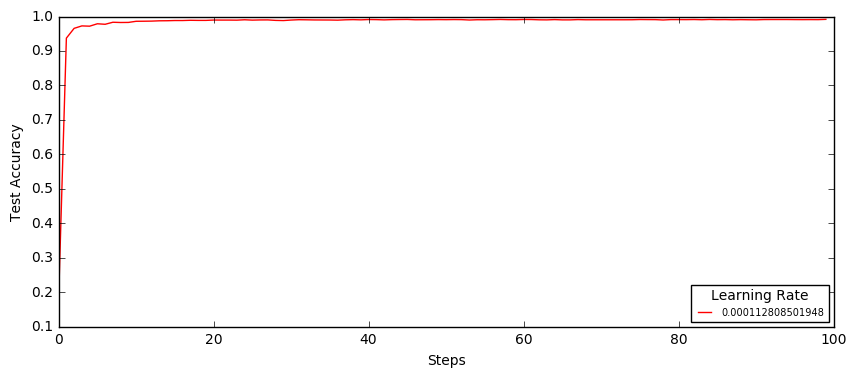

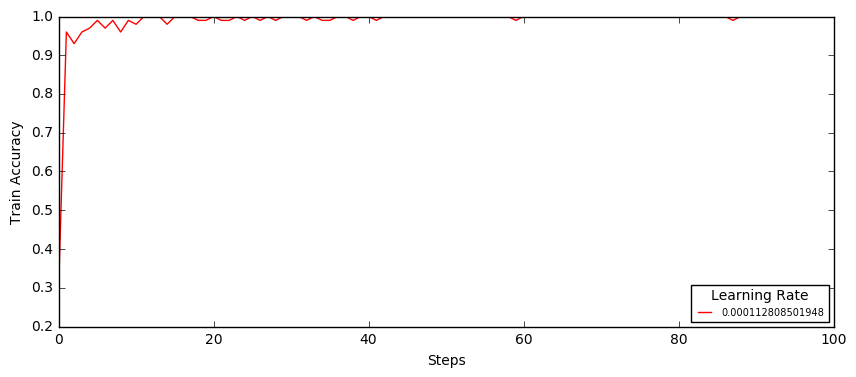

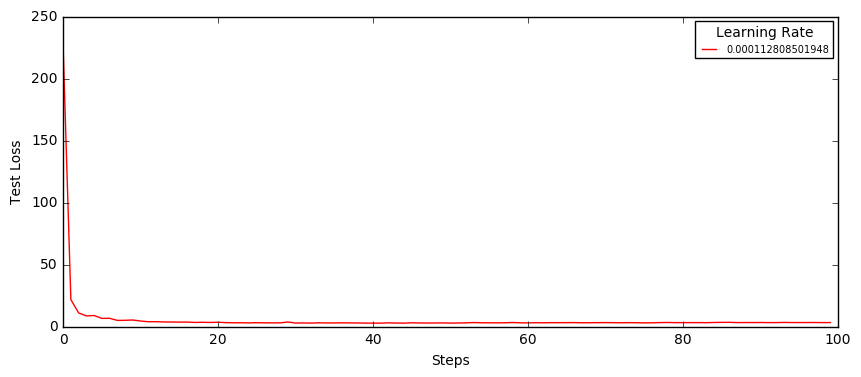

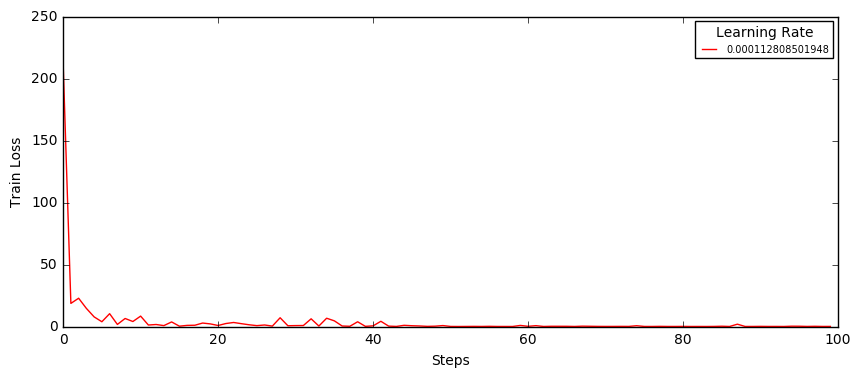

In [11]:
plot_performance(acc_check, learning_rates, train_accuracy, train_loss, test_accuracy, test_loss)

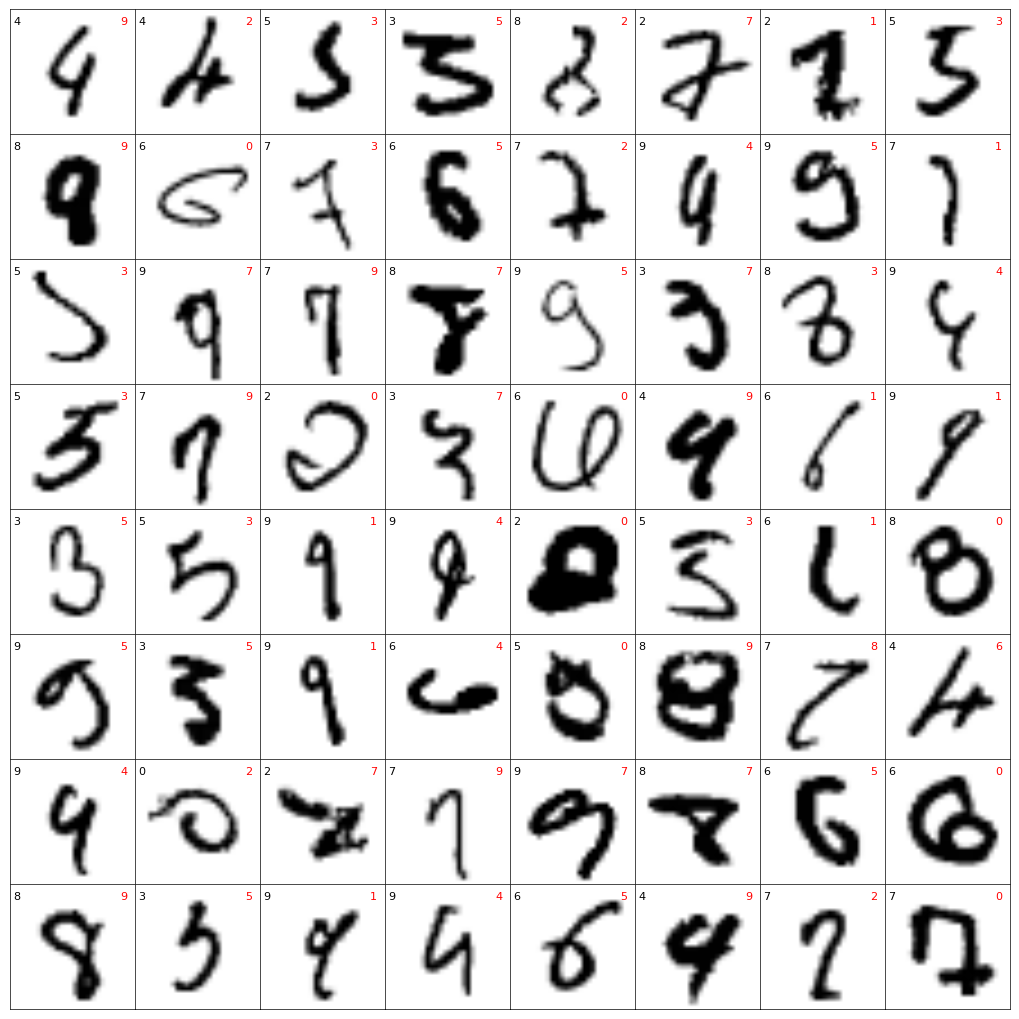

In [12]:
labels = np.argmax(mnist.test.labels, 1)
incorects = np.not_equal(labels, predictions)
plot_batch_images(mnist.test.images[incorects], labels[incorects], predictions[incorects], 64)